In [186]:
# |dmax - max d(k)|< epsilon
# 要知道什麼時候撞到 d_max
# 撞到 d_max後一個交易日進場 (從最後一天的帳戶餘額繼續)
# 用原來的gamma和他的上下界 (長期趨勢)

In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import yfinance as yf
import math
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

data = yf.download('TSLA', start = '2021-01-18', end = '2022-01-18')

Prices = pd.DataFrame(data['Adj Close'])
return_for_Prices = Prices.pct_change(1).dropna()
print(Prices.head(10))
print(return_for_Prices.head(10))

N = len(Prices) # days
print('總共', N, '個交易日')
M = len(return_for_Prices)
print('總共', M, '個報酬')
t1 = int(N / 4)  # 自訂
print('第一期有', t1, '個交易日')
p = 20  # 自訂restart取值日子長度

def GammaBound(t0, t1):
    '''找每個時段的gamma上下界'''
    # constraint set of gamma(t= 0~ t1)
    return_for_Prices_t = return_for_Prices.iloc[t0:t1, :]
    max_Xt = return_for_Prices_t.max()
    min_Xt = return_for_Prices_t.min()
    max_gamma = 1/abs(float(min_Xt))
    min_gamma = -1/float(max_Xt)
    return max_gamma, min_gamma

[*********************100%***********************]  1 of 1 completed
             Adj Close
Date                  
2021-01-19  844.549988
2021-01-20  850.450012
2021-01-21  844.989990
2021-01-22  846.640015
2021-01-25  880.799988
2021-01-26  883.090027
2021-01-27  864.159973
2021-01-28  835.429993
2021-01-29  793.530029
2021-02-01  839.809998
            Adj Close
Date                 
2021-01-20   0.006986
2021-01-21  -0.006420
2021-01-22   0.001953
2021-01-25   0.040348
2021-01-26   0.002600
2021-01-27  -0.021436
2021-01-28  -0.033246
2021-01-29  -0.050154
2021-02-01   0.058322
2021-02-02   0.039271
總共 252 個交易日
總共 251 個報酬
第一期有 63 個交易日


In [282]:
# 用過去的資料找第一個r*

pre_data = yf.download('TSLA', start = '2020-01-18', end = '2021-01-18')
pre_Prices = pd.DataFrame(pre_data['Adj Close'])
pre_return_for_Prices = pre_Prices.pct_change(1).dropna()
preN = len(pre_Prices)

# print(pre_Prices.tail(p))
# print(pre_return_for_Prices.tail(p))
l =[]
for k in range(preN-p-1, preN-1):
    l.append(float(pre_return_for_Prices.iloc[k]))
print(l)
print(len(l))

def preGammaBound(t0, t1):
    '''找每個時段的gamma'''
    # constraint set of gamma(t= 0~ t1)
    return_for_Prices_t = pre_return_for_Prices.iloc[t0:t1, :]
    max_Xt = return_for_Prices_t.max()
    min_Xt = return_for_Prices_t.min()
    max_gamma = 1/abs(float(min_Xt))
    min_gamma = -1/float(max_Xt)
    return max_gamma, min_gamma

def preJ(t0, t1, max_d, gamma):
    '''Objective Function'''
    max_V = 1
    Vk = 1
    maxd = 0
    for k in range(t0, t1-t0):
        dk = (max_V-Vk)/max_V
        Mk = (max_d-dk)/(1-dk)
        Vk1 = Vk * (1 + (gamma*Mk*float(pre_return_for_Prices.iloc[k])))
        if Vk1 >= max_V:
            max_V = Vk1
        if dk >= maxd:
            maxd = dk
        Vk = Vk1
    return math.log(Vk)/((t1-t0)**2), Vk, maxd

def preGetGamma(t0, t1, dmax):
    '''從歷史資料找最佳的gamma'''
    max_gamma, min_gamma = preGammaBound(t0, t1)
    # 生成1000個區間內的gamma
    r_list = []
    Jr_list = []
    for r in range(100):
        r = np.random.uniform(min_gamma, max_gamma)
        r_list.append(r)
        Jr_list.append(preJ(t0, t1, dmax, r)[0])
    # 從模擬結果找最佳的gamma
    index = Jr_list.index(max(Jr_list))
    gamma_star = r_list[index]
    return r_list, Jr_list
    # return max(Jr_list), gamma_star, index

# 找第一個r*
maxd = 0.05
print(preN)
print(preN-p)
first_r = preGetGamma(preN-127, preN, maxd)
print(first_r)

[*********************100%***********************]  1 of 1 completed
[0.05319781595740425, 0.059612706404252425, -0.0649496613646583, -0.01464924554624425, 0.008807748035020602, 0.02444354243151947, 0.0029012842127786875, 0.003465454933038181, 0.04322893659763305, 0.015673958884946604, 0.03415199343141406, 0.0073173269350561565, 0.028390302856798444, 0.07944654502802195, 0.07840307243104516, -0.0782141491809546, 0.047152947996006445, 0.005850879036589651, -0.011013416790886965, -0.02229588976978547]
20
252
232
([2.223137220559365, 2.941887820174098, 0.13479682879425336, 3.6127549251807745, 2.126481855889941, -2.138217973576369, 3.801454411649492, -5.969301288295387, -4.327053915312891, 4.662558548996194, 3.3784224011355244, 3.1645660949564034, -1.4620937512237138, 3.372808763338999, -1.3719549231595431, 0.06242774771821402, -0.9138410483110313, 0.9471552883275054, -6.1034348121132656, 3.1291640848320723, -4.531182099355192, -3.550111101450571, -1.218512829112763, -4.273396848703756, -0

In [279]:
#　測試函數是否可用
#　時間不同好像不一定
print(preJ(253-126, 253, 0.05, -3))

(0.0, 1, 0)


In [267]:
# 測試函數可用與否
max_d = 0.05
V_start = 10000
r1 = GetGamma(0, t1, max_d, V_start)
print(r1)

Exception in thread Thread-66:
Traceback (most recent call last):
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\urllib3\connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\urllib3\connectionpool.py", line 382, in _make_request
    self._validate_conn(conn)
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\urllib3\connectionpool.py", line 1010, in _validate_conn
    conn.connect()
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\urllib3\connection.py", line 411, in connect
    self.sock = ssl_wrap_socket(
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\urllib3\util\ssl_.py", line 428, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\urllib3\util\ssl_.py", line 472, in _ss

(5.65291509035918e-06, -5.072639423417805)


In [142]:
# 測試函數可用與否
max_d = 0.05
V_start = 10000
r2 = GetGamma(0, N-1, max_d, V_start)
print(r2)

(3.444845060166852e-07, -5.001865710841737)


In [ ]:
# out-of-sample (the last 0.5 year)

ep = 0.005  # epsilon
max_d = 0.05
V_start = 10000
V_all_o1 = [V_start]
hits = [0]
d_list = [0]
t_o1 = int(N / 2)

# find r* by using data from (0, 0.5)
r_o1 = GetGamma(hits[-1], t_o1, max_d, V_all_o1[-1])[1]
V_list_o10, hit_o10, d_list_o10 = MaxDD_restart2(hits[-1], t_o1, r_o1, max_d, ep, V_all_o1[-1])
V_all_o1 += V_list_o10[1:]
if hit_o10 != 0:
    hit_o10 += hits[-1]
    hits.append(hit_o10)
d_list += d_list_o10
print('最大跌幅:', max(d_list), d_list.index(max(d_list)))
print('每期帳戶餘額:', V_all_o1, len(V_all_o1))
print('撞到限制的期數:', hits[1:])

count = 0
while len(V_all_o1) <= (M/2):
    count += 1
    if hits[-1] < 20:
        pretime = hits[-1]
    else:
        pretime = 20
    ri = GetGamma(hits[-1]-pretime, hits[-1], max_d, V_all1[-1])[1]
    Vi_list, hit, di_list = MaxDD_restart2(hits[-1], M, ri, max_d, ep, V_all1[-1])
    V_all1 += Vi_list[1:]
    d_list += di_list[1:]
    print('最大跌幅:', max(d_list), d_list.index(max(d_list)))
    if hit != 0:
        hit += hits[-1]
        hits.append(hit)
# print('迴圈跑了', count, '次')
hits = hits[1:]
print('每期帳戶餘額:', V_all1, len(V_all1))
print('撞到限制的期數:', hits)

# 時間和帳戶餘額的關係
Vk_data2 = pd.DataFrame.copy(Prices)
Vk_data2 = Vk_data2.assign(DDKelly1 = V_all1)
Vk_data2 = Vk_data2.assign(d_max = d_list)
Vk_data2 = Vk_data2.drop('Adj Close', axis=1)
Vk_data2.columns=["epsilon=0.005", "d_max"]
print(Vk_data2.head(10))
print('整體最大跌幅:', max(d_list), d_list.index(max(d_list)))
print('最後一天的帳戶餘額:', V_all1[-1])
return_DD1 = (V_all1[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DD1)

Vk_data3 = pd.DataFrame.copy(Vk_data2)
Vk_data3 = Vk_data3.drop('d_max', axis=1)
Vk_data3.plot(title = "Account Value (TSLA, with restart, epsilon=0.005)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig3 = plt.gcf()
fig3.savefig('DrawdownKellyTSLArestart0.005.pdf', format='pdf', dpi=1000)
fig3.savefig('DrawdownKellyTSLArestart0.005.eps', format='eps', dpi=1000)
plt.show()

In [ ]:
# 沒辦法用原來的gamma (t= 0 ~ N) 來找到所有hit的點，再以各時間點的資料來找新的gamma
# 改用各hit和最後交易日的資料來找新的gamma

In [138]:
def MaxDD_restart1(t0, t1, dmax, epsilon, V_start):
    '''如果撞到限制（|dmax - max d(k)|< epsilon）就出場，帳戶餘額留在沒撞到的上個時間點'''
    Vi_list = [V_start]  # 放每一期的帳戶餘額
    max_Vi = V_start  # V_max
    Vi = V_start  # V(i)
    max_dk = 0
    hit = 0
    gamma = GetGamma(t0, t1, max_d, V_start)[1]
    for i in range(0, t1-t0):
        di = (max_Vi-Vi) / max_Vi
        if di >= max_dk:
            max_dk = di
        if abs(dmax - max_dk) < epsilon:
            hit = i
            break
        Mi = (max_d-di) / (1-di)
        Vi_1 = Vi * (1 + (gamma*Mi*float(return_for_Prices.iloc[i])))
        Vi_list.append(Vi_1)
        if Vi_1 >= max_Vi:
            max_Vi = Vi_1
        Vi = Vi_1
    return Vi_list, hit

ep = 0.005  # epsilon
V_all = [V_start]
hits = [0]
while len(V_all) <= M:
    Vi_list, hit = MaxDD_restart1(hits[-1], M, max_d, ep, V_all[-1])  # 上個restart日到最後一天
    V_all += Vi_list[1:]
    if hit != 0:
        hit += hits[-1]
        hits.append(hit)
hits = hits[1:]
print('每期帳戶餘額:', V_all)
print('撞到限制的期數:', hits)

每期帳戶餘額: [10000, 9982.240612816962, 9997.981851487702, 9993.037812988214, 9891.896524783288, 9886.716086247188, 9928.863276387647, 10001.355190296917, 10128.870390972017, 9978.697954506473, 9907.56359093144, 9937.627878000407, 9946.440547441558, 9942.099193668724, 9920.758529490446, 9945.282510533769, 10031.54446280148, 10013.866474433557, 10002.930508371091, 10050.102903288265, 10044.832052000413, 10073.811540660992, 10091.532888305412, 10295.452545093181, 10352.815794948636, 10190.199970138718, 10335.670269231316, 10360.73554263535, 10193.347058502955, 10272.730679400667, 10378.604482311779, 10506.888611880971, 10607.850458575831, 10765.469749099162, 10227.942147663463, 10245.466748838038, 10229.333984926723, 10234.086297276686, 10333.2208429454, 10339.81004360452, 10285.448615445881, 10210.002734485306, 10114.749111125731, 10198.265017822352, 10270.588221692933, 10225.038746399823, 10214.18912478261, 10219.248312695392, 10244.781202250308, 10211.315763171033, 10111.170684856166, 1012

In [139]:
print(len(V_all))
print(len(Prices))

252
252


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


            DrawdownKelly1
Date                      
2021-01-19    10000.000000
2021-01-20     9982.240613
2021-01-21     9997.981851
2021-01-22     9993.037813
2021-01-25     9891.896525
2021-01-26     9886.716086
2021-01-27     9928.863276
2021-01-28    10001.355190
2021-01-29    10128.870391
2021-02-01     9978.697955
最後一天的帳戶餘額: 10216.011698750355
最後一天和第一天相比的報酬率: 0.02160116987503552


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


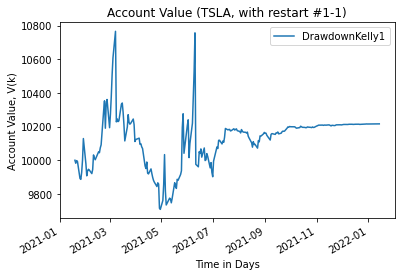

In [140]:
# 時間和帳戶餘額的關係
Vk_data1 = pd.DataFrame.copy(Prices)
Vk_data1 = Vk_data1.assign(DrawdownKelly1 = V_all)
Vk_data1 = Vk_data1.drop('Adj Close', axis=1)
print(Vk_data1.head(10))

print('最後一天的帳戶餘額:', V_all[-1])
return_DD1 = (V_all[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DD1)

Vk_data1.plot(title = "Account Value (TSLA, with restart #1-1)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig3_1 = plt.gcf()
fig3_1.savefig('DrawdownKellyTSLArestart1-1.pdf', format='pdf', dpi=1000)
fig3_1.savefig('DrawdownKellyTSLArestart1-1.eps', format='eps', dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


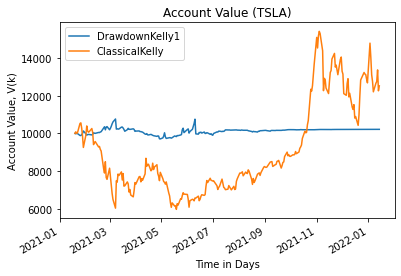

In [141]:
Vk_data1 = Vk_data1.assign(ClassicalKelly = Vk_K_list_)
Vk_data1.plot(title = "Account Value (TSLA)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig4_2 = plt.gcf()
fig4_2.savefig('AccountValueKellyTSLA-diffgamma.pdf', format='pdf', dpi=1000)
fig4_2.savefig('AccountValueKellyTSLA-diffgamma.eps', format='eps', dpi=1000)
plt.show()

In [2]:
def MaxDD_restart2(t0, t1, gamma, dmax, epsilon, V_start):
    '''如果撞到限制（|dmax - max d(k)|< epsilon）就出場，帳戶餘額留在沒撞到的上個時間點'''
    Vi_list = [V_start]  # 放每一期的帳戶餘額
    max_Vi = V_start  # V_max
    Vi = V_start  # V(i)
    max_dk = 0
    hit = 0
    d_list = []
    for i in range(0, t1-t0):
        di = (max_Vi-Vi) / max_Vi
        d_list.append(di)
        if di >= max_dk:
            max_dk = di
        if abs(dmax - max_dk) < epsilon:
            hit = i
            break
        if i+t0 != N-1:
            Mi = (max_d-di) / (1-di)
            Vi_1 = Vi * (1 + (gamma*Mi*float(return_for_Prices.iloc[i+t0])))
            Vi_list.append(Vi_1)
            if Vi_1 >= max_Vi:
                max_Vi = Vi_1
            Vi = Vi_1
    return Vi_list, hit, d_list

def GetGamma(t0, t1, dmax, V_start):
    '''從歷史資料找最佳的gamma'''
    max_gamma, min_gamma = GammaBound(t0, t1-1)
    # 生成1000個區間內的gamma
    r_list = []
    Jr_list = []
    for r in range(1000):
        r = np.random.uniform(min_gamma, max_gamma)
        r_list.append(r)
        Jr_list.append(J(t0, t1, dmax, r, V_start))
    # 從模擬結果找最佳的gamma
    index = Jr_list.index(max(Jr_list))
    gamma_star = r_list[index]
    return max(Jr_list), gamma_star

def J(t0, t1, max_d, gamma, V_start):
    '''Objective Function，回傳最後一天的J值、帳戶餘額和最大跌幅'''
    max_V = V_start
    Vk = V_start
    maxd = 0
    # k的個數會比天數少1
    for k in range(t0, t1-t0-1):
        dk = (max_V-Vk)/max_V
        Mk = (max_d-dk)/(1-dk)
        Vk1 = Vk * (1 + (gamma*Mk*float(return_for_Prices.iloc[k])))
        if Vk1 >= max_V:
            max_V = Vk1
        if dk >= maxd:
            maxd = dk
        Vk = Vk1
    return math.log(Vk)/((t1-t0)**2), Vk, maxd

fixed gamma: -5.087457411065031
撞到限制的期數: [34, 189, 242]
            epsilon=0.005     d_max
Date                               
2021-01-19   10000.000000  0.000000
2021-01-20    9964.459033  0.003554
2021-01-21    9995.960456  0.000404
2021-01-22    9986.066233  0.001393
2021-01-25    9783.659198  0.021634
2021-01-26    9773.293618  0.022671
2021-01-27    9857.625556  0.014237
2021-01-28   10002.682887  0.000000
2021-01-29   10257.906509  0.000000
2021-02-01    9953.545364  0.029671
            epsilon=0.005     d_max
Date                               
2022-01-03    8770.081624  0.097735
2022-01-04    8956.728420  0.000000
2022-01-05    9200.380562  0.000000
2022-01-06    9301.124168  0.000000
2022-01-07    9468.854180  0.000000
2022-01-10    9322.689437  0.015436
2022-01-11    9298.512093  0.017990
2022-01-12    9143.293024  0.034382
2022-01-13    9356.629481  0.011852
2022-01-14    9282.328989  0.019699
整體最大跌幅: 0.09992382370504853 34
最後一天的帳戶餘額: 9282.328989398537
最後一天和第一天相比的報酬率: -0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


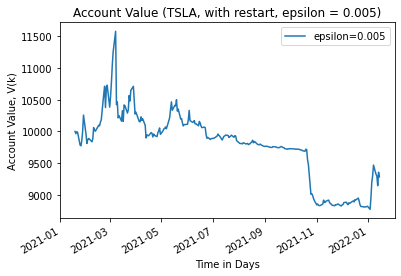

In [3]:
# 改成全年不變的固定gamma
# 固定epsilon=0.005

ep = 0.005  # epsilon
max_d = 0.1
V_start = 10000
V_allf = [V_start]
hits = [0]
d_list = [0]

r0 = GetGamma(0, N, max_d, V_allf[-1])[1]
print('fixed gamma:', r0)

while len(V_allf) < N:
    Vi_list, hit, di_list = MaxDD_restart2(hits[-1], N, r0, max_d, ep, V_allf[-1])  # 上個restart日到最後一天
    V_allf += Vi_list[1:]
    d_list += di_list[1:]
    if hit != 0:
        hit += hits[-1]
        hits.append(hit)

hits = hits[1:]

print('撞到限制的期數:', hits)

# 時間和帳戶餘額的關係
Vk_dataf = pd.DataFrame.copy(Prices)
Vk_dataf = Vk_dataf.assign(DDKelly_fixed = V_allf)
Vk_dataf = Vk_dataf.assign(d_max = d_list)
Vk_dataf = Vk_dataf.drop('Adj Close', axis=1)
Vk_dataf.columns=["epsilon=0.005", "d_max"]
print(Vk_dataf.head(10))
print(Vk_dataf.tail(10))
print('整體最大跌幅:', max(d_list), d_list.index(max(d_list)))
print('最後一天的帳戶餘額:', V_allf[-1])
return_DDf = (V_allf[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DDf)

Vk_dataf1 = pd.DataFrame.copy(Vk_dataf)
Vk_dataf1 = Vk_dataf1.drop('d_max', axis=1)
Vk_dataf1.plot(title = "Account Value (TSLA, with restart, epsilon = 0.005)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig = plt.gcf()
fig.savefig('DrawdownKellyTSLArestartFixed0.1.pdf', format='pdf', dpi=1000)
fig.savefig('DrawdownKellyTSLArestartFixed0.1.eps', format='eps', dpi=1000)
plt.show()

In [4]:
print(len(d_list))

252


最大跌幅: 0.09544207005630877 129
最大跌幅: 0.13975529841760548 132
189
撞到限制的期數: [192]
            epsilon=0.005     d_max
Date                               
2021-04-20   10000.000000  0.000000
2021-04-21    9822.068657  0.017793
2021-04-22    9959.463737  0.004054
2021-04-23    9893.563642  0.010644
2021-04-26    9838.682327  0.016132
2021-04-27   10032.205240  0.000000
2021-04-28   10107.137585  0.000000
2021-04-29   10236.066710  0.000000
2021-04-30    9986.372745  0.024394
2021-05-03   10122.653083  0.011080
整體最大跌幅: 0.13975529841760548 132
最後一天的帳戶餘額: 9017.518423538728
最後一天和第一天相比的報酬率: -0.09824815764612722


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


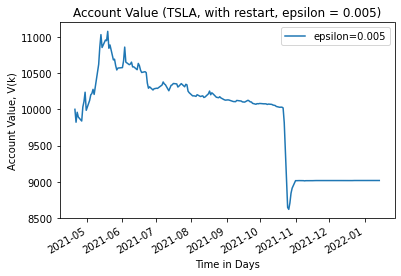

In [12]:
# 改成restart日和前t1日算出來的gamma

ep = 0.005  # epsilon
max_d = 0.1
V_start = 10000
V_all1 = [V_start]
hits = [t1]
d_list = [0]

while len(V_all1) < N-t1:
    pretime = t1
    ri = GetGamma(hits[-1]-pretime, hits[-1], max_d, V_all1[-1])[1]
    Vi_list, hit, di_list = MaxDD_restart2(hits[-1], N, ri, max_d, ep, V_all1[-1])
    V_all1 += Vi_list[1:]
    d_list += di_list[1:]
    print('最大跌幅:', max(d_list), d_list.index(max(d_list)))
    if hit != 0 and hit <= N-t1:
        hit += hits[-1]
        hits.append(hit)
hits = hits[1:]
print(len(V_all1))
print('撞到限制的期數:', hits)

# 時間和帳戶餘額的關係
Vk_data2 = pd.DataFrame.copy(Prices[t1:])
Vk_data2 = Vk_data2.assign(DDKelly1 = V_all1)
Vk_data2 = Vk_data2.assign(d_max = d_list)
Vk_data2 = Vk_data2.drop('Adj Close', axis=1)
Vk_data2.columns=["epsilon=0.005", "d_max"]
print(Vk_data2.head(10))
print('整體最大跌幅:', max(d_list), d_list.index(max(d_list)))
print('最後一天的帳戶餘額:', V_all1[-1])
return_DD1 = (V_all1[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DD1)

Vk_data3 = pd.DataFrame.copy(Vk_data2)
Vk_data3 = Vk_data3.drop('d_max', axis=1)
Vk_data3.plot(title = "Account Value (TSLA, with restart, epsilon = 0.005)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig3 = plt.gcf()
fig3.savefig('DrawdownKellyTSLArestart0.005_0.1.pdf', format='pdf', dpi=1000)
fig3.savefig('DrawdownKellyTSLArestart0.005_0.1.eps', format='eps', dpi=1000)
plt.show()

In [6]:
print(len(d_list))

189


最大跌幅: 0.09086400148229867 111
最大跌幅: 0.09086400148229867 111
每期帳戶餘額: 189
撞到限制的期數: [174]
            epsilon=0.01     d_max
Date                              
2021-04-20  10000.000000  0.000000
2021-04-21   9822.248373  0.017775
2021-04-22   9959.534686  0.004047
2021-04-23   9893.696284  0.010630
2021-04-26   9838.862262  0.016114
2021-04-27  10032.231189  0.000000
2021-04-28  10107.088043  0.000000
2021-04-29  10235.886315  0.000000
2021-04-30   9986.448945  0.024369
2021-05-03  10122.633601  0.011064
整體最大跌幅: 0.09086400148229867 111
最後一天的帳戶餘額: 9740.30233316287
最後一天和第一天相比的報酬率: -0.025969766683712987


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


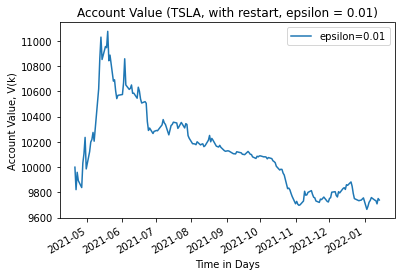

In [8]:
ep = 0.01  # epsilon
max_d = 0.1
V_start = 10000
V_all2 = [V_start]
hits = [t1]
d_list = [0]

while len(V_all2) < N-t1:
    pretime = t1
    ri = GetGamma(hits[-1]-pretime, hits[-1], max_d, V_all2[-1])[1]
    Vi_list, hit, di_list = MaxDD_restart2(hits[-1], N, ri, max_d, ep, V_all2[-1])
    V_all2 += Vi_list[1:]
    d_list += di_list[1:]
    print('最大跌幅:', max(d_list), d_list.index(max(d_list)))
    if hit != 0 and hit <= N-t1:
        hit += hits[-1]
        hits.append(hit)
hits = hits[1:]
print('每期帳戶餘額:', len(V_all2))
print('撞到限制的期數:', hits)

# 時間和帳戶餘額的關係
Vk_data4 = pd.DataFrame.copy(Prices[t1:])
Vk_data4 = Vk_data4.assign(DDKelly2 = V_all2)
Vk_data4 = Vk_data4.assign(d_max = d_list)
Vk_data4 = Vk_data4.drop('Adj Close', axis=1)
Vk_data4.columns=["epsilon=0.01", "d_max"]
print(Vk_data4.head(10))
print('整體最大跌幅:', max(d_list), d_list.index(max(d_list)))
print('最後一天的帳戶餘額:', V_all2[-1])
return_DD2 = (V_all2[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DD2)

Vk_data5 = pd.DataFrame.copy(Vk_data4)
Vk_data5 = Vk_data5.drop('d_max', axis=1)
Vk_data5.plot(title = "Account Value (TSLA, with restart, epsilon = 0.01)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig5 = plt.gcf()
fig5.savefig('DrawdownKellyTSLArestart0.01_0.1.pdf', format='pdf', dpi=1000)
fig5.savefig('DrawdownKellyTSLArestart0.01_0.1.eps', format='eps', dpi=1000)
plt.show()

最大跌幅: 0.09904122161914829 135
最大跌幅: 0.09904122161914829 135
189
撞到限制的期數: [198]
            epsilon=0.001     d_max
Date                               
2021-04-20   10000.000000  0.000000
2021-04-21    9823.368417  0.017663
2021-04-22    9959.975494  0.004002
2021-04-23    9894.521896  0.010548
2021-04-26    9839.983055  0.016002
2021-04-27   10032.390261  0.000000
2021-04-28   10106.776609  0.000000
2021-04-29   10234.759357  0.000000
2021-04-30    9986.921024  0.024215
2021-05-03   10122.507379  0.010968
整體最大跌幅: 0.09904122161914829 135
最後一天的帳戶餘額: 9966.634694556933
最後一天和第一天相比的報酬率: -0.0033365305443066972


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


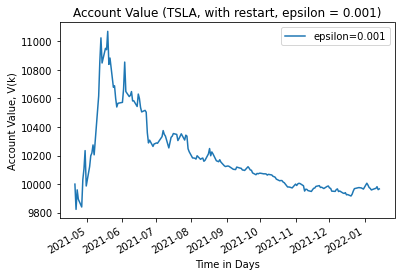

In [9]:
ep = 0.001  # epsilon
max_d = 0.1
V_start = 10000
V_all3 = [V_start]
hits = [t1]
d_list = [0]

while len(V_all3) < N-t1:
    pretime = t1
    ri = GetGamma(hits[-1]-pretime, hits[-1], max_d, V_all3[-1])[1]
    Vi_list, hit, di_list = MaxDD_restart2(hits[-1], N, ri, max_d, ep, V_all3[-1])
    V_all3 += Vi_list[1:]
    d_list += di_list[1:]
    print('最大跌幅:', max(d_list), d_list.index(max(d_list)))
    if hit != 0 and hit <= N-t1:
        hit += hits[-1]
        hits.append(hit)
hits = hits[1:]
print(len(V_all3))
print('撞到限制的期數:', hits)

# 時間和帳戶餘額的關係
Vk_data6 = pd.DataFrame.copy(Prices[t1:])
Vk_data6 = Vk_data6.assign(DDKelly3 = V_all3)
Vk_data6 = Vk_data6.assign(d_max = d_list)
Vk_data6 = Vk_data6.drop('Adj Close', axis=1)
Vk_data6.columns=["epsilon=0.001", "d_max"]
print(Vk_data6.head(10))
print('整體最大跌幅:', max(d_list), d_list.index(max(d_list)))
print('最後一天的帳戶餘額:', V_all3[-1])
return_DD3 = (V_all3[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DD3)

Vk_data7 = pd.DataFrame.copy(Vk_data6)
Vk_data7 = Vk_data7.drop('d_max', axis=1)
Vk_data7.plot(title = "Account Value (TSLA, with restart, epsilon = 0.001)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig7 = plt.gcf()
fig7.savefig('DrawdownKellyTSLArestart0.001_0.1.pdf', format='pdf', dpi=1000)
fig7.savefig('DrawdownKellyTSLArestart0.001_0.1.eps', format='eps', dpi=1000)
plt.show()

最大跌幅: 0.09987532221253463 179
189
撞到限制的期數: []
               epsilon=0     d_max
Date                              
2021-04-20  10000.000000  0.000000
2021-04-21   9822.114080  0.017789
2021-04-22   9959.481675  0.004052
2021-04-23   9893.597172  0.010640
2021-04-26   9838.727808  0.016127
2021-04-27  10032.211810  0.000000
2021-04-28  10107.125075  0.000000
2021-04-29  10236.021127  0.000000
2021-04-30   9986.392017  0.024387
2021-05-03  10122.648179  0.011076
整體最大跌幅: 0.09987532221253463 179
最後一天的帳戶餘額: 9970.943707935154
最後一天和第一天相比的報酬率: -0.0029056292064846274


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


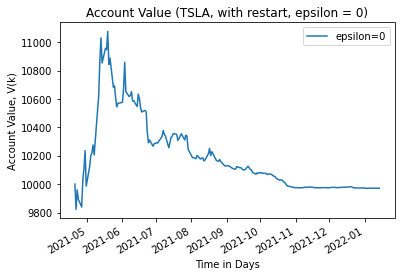

In [10]:
ep = 0  # epsilon
max_d = 0.1
V_start = 10000
V_all4 = [V_start]
hits = [t1]
d_list = [0]

while len(V_all4) < N-t1:
    pretime = t1
    ri = GetGamma(hits[-1]-pretime, hits[-1], max_d, V_all4[-1])[1]
    Vi_list, hit, di_list = MaxDD_restart2(hits[-1], N, ri, max_d, ep, V_all4[-1])
    V_all4 += Vi_list[1:]
    d_list += di_list[1:]
    print('最大跌幅:', max(d_list), d_list.index(max(d_list)))
    if hit != 0 and hit <= N-t1:
        hit += hits[-1]
        hits.append(hit)
hits = hits[1:]
print(len(V_all4))
print('撞到限制的期數:', hits)

# 時間和帳戶餘額的關係
Vk_data8 = pd.DataFrame.copy(Prices[t1:])
Vk_data8 = Vk_data8.assign(DDKelly3 = V_all4)
Vk_data8 = Vk_data8.assign(d_max = d_list)
Vk_data8 = Vk_data8.drop('Adj Close', axis=1)
Vk_data8.columns=["epsilon=0", "d_max"]
print(Vk_data8.head(10))
print('整體最大跌幅:', max(d_list), d_list.index(max(d_list)))
print('最後一天的帳戶餘額:', V_all4[-1])
return_DD4 = (V_all4[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DD4)

Vk_data9 = pd.DataFrame.copy(Vk_data8)
Vk_data9 = Vk_data9.drop('d_max', axis=1)
Vk_data9.plot(title = "Account Value (TSLA, with restart, epsilon = 0)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig9 = plt.gcf()
fig9.savefig('DrawdownKellyTSLArestart0.0_0.1.pdf', format='pdf', dpi=1000)
fig9.savefig('DrawdownKellyTSLArestart0.0_0.1.eps', format='eps', dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


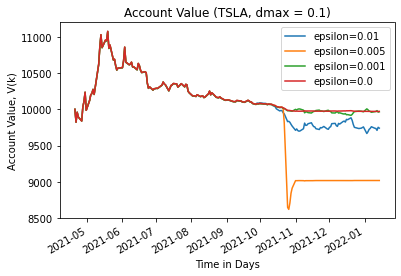

In [13]:
Vk_data10 = pd.DataFrame.copy(Vk_data5)
Vk_data10 = Vk_data10.assign(DDKelly1 = V_all1)
Vk_data10 = Vk_data10.assign(DDKelly3 = V_all3)
Vk_data10 = Vk_data10.assign(DDKelly4 = V_all4)
Vk_data10.columns=["epsilon=0.01", "epsilon=0.005", "epsilon=0.001", "epsilon=0.0"]
Vk_data10.plot(title = "Account Value (TSLA, dmax = 0.1)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig10 = plt.gcf()
fig10.savefig('CompareEp_TSLA_0.1.pdf', format='pdf', dpi=1000)
fig10.savefig('CompareEp_TSLA_0.1.eps', format='eps', dpi=1000)
plt.show()

# 以下先不管

max(Mk): 0.05
min(Mk): 0
max(d*): 0.031107854136730888
V_last: 10001.875060922066
return: 0.00018750609220660408


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


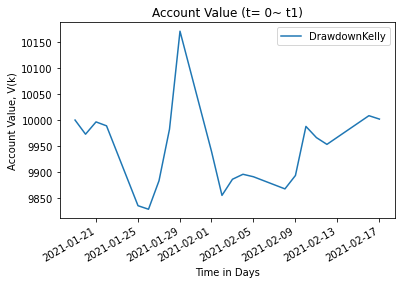

In [47]:
# Max Drawdown(without restart)

Vk_list = [V_start]
max_V_ = V_start
Vk_ = V_start
max_Mk = 0
min_Mk = 0
max_d_star = 0
dk_list = []
Mk_list = []

for k in range(t1-1):
    dk = (max_V_-Vk_) / max_V_
    Mk = (max_d-dk) / (1-dk)
    dk_list.append(dk)
    Mk_list.append(Mk)
    Vk1_ = Vk_ * (1 + (gamma_star005*Mk*float(return_for_Prices.iloc[k])))
    Vk_list.append(Vk1_)
    if Vk1_ >= max_V_:
        max_V_ = Vk1_
    if Mk >= max_Mk:
        max_Mk = Mk
    if Mk <= min_Mk:
        min_Mk = Mk
    if dk >= max_d_star:
        max_d_star = dk
    Vk_ = Vk1_
'''
for i in range(1, len(dk_list)):
    if dk_list[i] == dk_list[i-1]:
        print(i)
for i in range(1, len(Mk_list)):
    if Mk_list[i] == Mk_list[i-1]:
        print(i)
for i in range(len(Vk_list)):
    print(i, Vk_list[i])
'''
# 時間和帳戶餘額的關係
Vk_data = pd.DataFrame.copy(Prices)
Vk_data = Vk_data.iloc[0:t1,:]
Vk_data = Vk_data.assign(DrawdownKelly = Vk_list)
Vk_data = Vk_data.drop('Adj Close', axis=1)

print('max(Mk):', max_Mk)
print('min(Mk):', min_Mk)
print('max(d*):', max_d_star)
print('V_last:', Vk_list[-1])
return_DD = (Vk_list[-1]-V_start) / V_start
print('return:', return_DD)

Vk_data.plot(title = "Account Value (t= 0~ t1)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig3 = plt.gcf()
fig3.savefig('DrawdownKellyTSLArestart-diffgamma.pdf', format='pdf', dpi=1000)
fig3.savefig('DrawdownKellyTSLArestart-diffgamma.eps', format='eps', dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


34 hit!
161 hit!
196 hit!
最後一天的帳戶餘額: 9121.389372831665
最後一天和第一天相比的報酬率: -0.08786106271683347


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


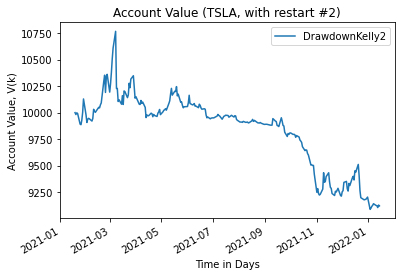

In [22]:
# 如果一段時間(自訂)股價變動幅度和帳戶餘額變動幅度差太多(自訂)，重新開始

def MaxDD_restart2(V0, k, dmax, epsilon):
    '''從第 k 期開始以V0跑，累積帳戶餘額'''
    Vi_list = [V0]  # 放每一期的帳戶餘額
    max_Vi = V0  # V_max
    Vi = V0  # V(i)
    for i in range(k, N-1):
        di = (max_Vi-Vi) / max_Vi
        Mi = (max_d-di) / (1-di)
        Vi_1 = Vi * (1 + (gamma_star005*Mi*float(return_for_Prices.iloc[i])))
        if abs(dmax - di) < epsilon:
            print(i, 'hit!')
            break  # 下一輪從第 k+1 天開始
        Vi_list.append(Vi_1)
        if Vi_1 >= max_Vi:
            max_Vi = Vi_1
        Vi = Vi_1
    return Vi_list

eps = 0.005  # epsilon
V_list2 = []
V_list2 += MaxDD_restart2(V_start, 0, max_d, eps)
while len(V_list2) < N:
    V_list2_1 = MaxDD_restart2(V_list2[-1], len(V_list2), max_d, eps)
    V_list2 += V_list2_1

# 時間和帳戶餘額的關係
Vk_data2 = pd.DataFrame.copy(Prices)
Vk_data2 = Vk_data2.assign(DrawdownKelly2 = V_list2)
Vk_data2 = Vk_data2.drop('Adj Close', axis=1)

print('最後一天的帳戶餘額:', V_list2[-1])
return_DD2 = (V_list2[-1]-V_start) / V_start
print('最後一天和第一天相比的報酬率:', return_DD2)

Vk_data2.plot(title = "Account Value (TSLA, with restart #2)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig3_2 = plt.gcf()
fig3_2.savefig('DrawdownKellyTSLArestart2-2.pdf', format='pdf', dpi=1000)
fig3_2.savefig('DrawdownKellyTSLArestart2-2.eps', format='eps', dpi=1000)
plt.show()

In [15]:
# cvxpy求最佳解 (用classical Kelly)->沒有drawdown control的情況

r = cp.Variable()

sum_E = 0
for k in range(N-1):
    sum_E += cp.log(1 + (float(return_for_Prices.iloc[k])*r))
J_E = sum_E / N

constraints = [min_gamma <= r, r <= max_gamma]
obj = cp.Maximize(J_E)
prob = cp.Problem(obj, constraints)
prob.solve()
print(r.value)
cvx_result = r.value

print('Put the cvx_result into J function and we get:', J(cvx_result))
print('The diff against the gamma from DD:', J(cvx_result)-max(Jr_list))

# 得到的結果和上面模擬1000個gamma的結果(1.2309 vs -5.0714)
# 和Max DD的gamma放入J()結果有差(2.0866 vs 3.5472)

1.2309298229587349
Put the cvx_result into J function and we get: 2.086606350986985e-07
The diff against the gamma from DD: -1.488537966341838e-07


NameError: name 'fig' is not defined

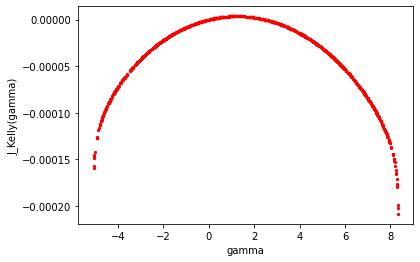

In [17]:
# Find gamma for classical Kelly

V_start_K = 10000

def J_Kelly(gamma):
    max_V_K = V_start_K
    Vk_K = V_start_K
    
    for k in range(N-1):
        dk = (max_V_K-Vk_K)/max_V_K
        Vk1_K = Vk_K * (1 + (gamma*float(return_for_Prices.iloc[k])))
        if Vk1_K >= max_V_K:
            max_V_K = Vk1_K
        Vk_K = Vk1_K
    return math.log(Vk_K/V_start_K)/((N-1)**2)
#gamma帶固定的值求得出結果

#生成1000個區間內的gamma
r_K_list = []
Jr_K_list = []
for r in range(1000):
    r = np.random.uniform(min_gamma, max_gamma)
    r_K_list.append(r)
    Jr_K_list.append(J_Kelly(r))
# 製作figure  
fig_K = plt.figure()   
# 圖表的設定
ax_K = fig_K.add_subplot(1, 1, 1)
# 散佈圖
ax_K.scatter(r_K_list, Jr_K_list, color='red', s=5)
plt.xlabel("gamma") 
plt.ylabel("J_Kelly(gamma)")
fig5 = plt.gcf()
fig5.savefig('gammaKellyTSLA.pdf', format='pdf',dpi=fig.dpi, bbox_inches='tight')
fig5.savefig('gammaKellyTSLA.eps', format='eps',dpi=fig.dpi, bbox_inches='tight')
plt.show()

In [18]:
index_K = Jr_K_list.index(max(Jr_K_list))
print(max(Jr_K_list))
gamma_star_K = r_K_list[index_K]
print(gamma_star_K)
print(J(gamma_star_K))  # 得到的gamma代入Max DD
print('The diff against the gamma from DD:', J(gamma_star_K)-max(Jr_list))

3.575053266853744e-06
1.228817669288417
2.0854581816109584e-07
The diff against the gamma from DD: -1.4896861357178646e-07


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


            DrawdownKelly1  ClassicalKelly
Date                                      
2022-01-03     9088.870505    14793.267296
2022-01-04     9099.991420    14032.822542
2022-01-05     9117.233486    13110.776681
2022-01-06     9126.062994    12764.018447
2022-01-07     9142.197441    12208.050928
2022-01-10     9125.894346    12663.225711
2022-01-11     9123.197933    12755.580313
2022-01-12     9105.887243    13371.418002
2022-01-13     9129.675709    12262.470741
2022-01-14     9121.389373    12526.132022
最後一天的帳戶餘額: 12526.132021677855
1.373270179539459 times
最後一天和第一天相比的報酬率: 0.2526132021677855
-2.8751439415424556 times
-2.7634978812517055 times
3.9282428653713386 times


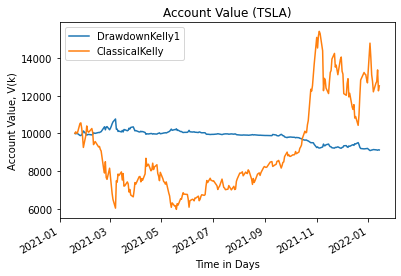

In [23]:
# Classial Kelly vs Restart#1
Vk_K_list_ = [V_start_K]
max_V_K_ = V_start_K
Vk_K_ = V_start_K
max_d_K_star = 0

for k in range(N-1):
    dk = (max_V_K_-Vk_K_)/max_V_K_
    Vk1_K_ = Vk_K_ * (1 + (gamma_star_K*float(return_for_Prices.iloc[k])))
    Vk_K_list_.append(Vk1_K_)
    if Vk1_K_ >= max_V_K_:
        max_V_K_ = Vk1_K_
    if dk >= max_d_K_star:
        max_d_K_star = dk
    Vk_K_ = Vk1_K_

Vk_data1 = Vk_data1.assign(ClassicalKelly = Vk_K_list_)
print(Vk_data1.tail(10))
'''
print('max(d*):', max_d_K_star)
print(max_d_K_star/max_d_star, 'times')
'''
print('最後一天的帳戶餘額:', Vk_K_list_[-1])
print(Vk_K_list_[-1]/V_list1[-1], 'times')
return_K = (Vk_K_list_[-1]-V_start_K)/V_start_K
print('最後一天和第一天相比的報酬率:', return_K)
print(return_K/return_DD1, 'times')
print((price_list[-1]-price_list[0])/(price_list[0]*return_DD1), 'times')
print(float(max_X)/max_d_star, 'times')

Vk_data1.plot(title = "Account Value (TSLA)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig4_1 = plt.gcf()
fig4_1.savefig('AccountValueKellyTSLA-diff.pdf', format='pdf', dpi=1000)
fig4_1.savefig('AccountValueKellyTSLA-diff.eps', format='eps', dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


            DrawdownKelly2  ClassicalKelly
Date                                      
2022-01-03     9088.870505    14793.267296
2022-01-04     9099.991420    14032.822542
2022-01-05     9117.233486    13110.776681
2022-01-06     9126.062994    12764.018447
2022-01-07     9142.197441    12208.050928
2022-01-10     9125.894346    12663.225711
2022-01-11     9123.197933    12755.580313
2022-01-12     9105.887243    13371.418002
2022-01-13     9129.675709    12262.470741
2022-01-14     9121.389373    12526.132022
1.373270179539459 times
-2.8751439415424556 times
-2.7634978812517055 times


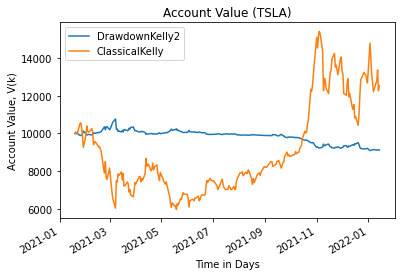

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


            DrawdownKelly1  DrawdownKelly2  ClassicalKelly
Date                                                      
2022-01-03     9088.870505     9088.870505    14793.267296
2022-01-04     9099.991420     9099.991420    14032.822542
2022-01-05     9117.233486     9117.233486    13110.776681
2022-01-06     9126.062994     9126.062994    12764.018447
2022-01-07     9142.197441     9142.197441    12208.050928
2022-01-10     9125.894346     9125.894346    12663.225711
2022-01-11     9123.197933     9123.197933    12755.580313
2022-01-12     9105.887243     9105.887243    13371.418002
2022-01-13     9129.675709     9129.675709    12262.470741
2022-01-14     9121.389373     9121.389373    12526.132022


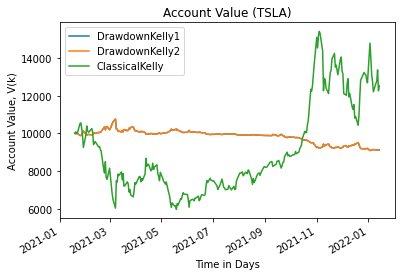

In [24]:
# Classial Kelly vs Restart#2

Vk_data2 = Vk_data2.assign(ClassicalKelly = Vk_K_list_)
print(Vk_data2.tail(10))

print(Vk_K_list_[-1]/V_list2[-1], 'times')

print(return_K/return_DD2, 'times')
print((price_list[-1]-price_list[0])/(price_list[0]*return_DD2), 'times')

Vk_data2.plot(title = "Account Value (TSLA)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig4_2 = plt.gcf()
fig4_2.savefig('AccountValueKellyTSLA-diffgamma.pdf', format='pdf', dpi=1000)
fig4_2.savefig('AccountValueKellyTSLA-diffgamma.eps', format='eps', dpi=1000)
plt.show()

Vk_data1 = Vk_data1.assign(DrawdownKelly2 = V_list2)
Vk_data1 = Vk_data1.reindex(columns=['DrawdownKelly1', 'DrawdownKelly2', 'ClassicalKelly'])
print(Vk_data1.tail(10))

Vk_data1.plot(title = "Account Value (TSLA)")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig4_3 = plt.gcf()
fig4_3.savefig('AccountValueKellyTSLA-diffgamma.pdf', format='pdf', dpi=1000)
fig4_3.savefig('AccountValueKellyTSLA-diffgamma.eps', format='eps', dpi=1000)
plt.show()

In [ ]:
# Classial Kelly
Vk_K_list_ = [V_start_K]
max_V_K_ = V_start_K
Vk_K_ = V_start_K
max_d_K_star = 0

for k in range(N-1):
    dk = (max_V_K_-Vk_K_)/max_V_K_
    Vk1_K_ = Vk_K_ * (1 + (gamma_star_K*float(return_for_Prices.iloc[k])))
    Vk_K_list_.append(Vk1_K_)
    if Vk1_K_ >= max_V_K_:
        max_V_K_ = Vk1_K_
    if dk >= max_d_K_star:
        max_d_K_star = dk
    Vk_K_ = Vk1_K_

Vk_data = Vk_data.assign(ClassicalKelly = Vk_K_list_)
print(Vk_data.head(10))
print('max(d*):', max_d_K_star)
print(max_d_K_star/max_d_star, 'times')
print('V_last:', Vk_K_list_[-1])
print(Vk_K_list_[-1]/Vk_list[-1], 'times')
return_K = (Vk_K_list_[-1]-V_start_K)/V_start_K
print('return:', return_K)
print(return_K/return_DD, 'times')
print((price_list[-1]-price_list[0])/(price_list[0]*return_DD), 'times')
print(float(max_X)/max_d_star, 'times')

Vk_data.plot(title = "Account Value")
plt.xlabel('Time in Days')
plt.ylabel('Account Value, V(k)')
fig4 = plt.gcf()
fig4.savefig('AccountValue(Kelly)(TSLA).pdf', format='pdf', dpi=1000)
fig4.savefig('AccountValue(Kelly)(TSLA).eps', format='eps', dpi=1000)
plt.show()